# Latent Semantic Analysis (LSA)

Librería LSA: https://radimrehurek.com/gensim/models/lsimodel.html

Librería Corpora Dic: https://radimrehurek.com/gensim/corpora/dictionary.html

Ejemplo:
- https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

Wikipedia:
https://en.wikipedia.org/wiki/Latent_semantic_analysis

In [2]:
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

unable to import 'smart_open.gcs', disabling that module


In [2]:
def loadTable(name):
    path = '../../Tables/'
    path += name + '.h5'
    return pd.read_hdf(path, 'df')

In [3]:
data = pd.read_table("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", sep=',')
#data['Diagnoses'] = data['Interventions'] + data['Diagnoses']
#data = data.drop(columns=["Interventions","Eligible"])
#data['Diagnoses']
#wordss = []

In [4]:
def load_data():
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    titles = []
    titles.append( data['Diagnoses'][0:min(len(data['Diagnoses']),2)] )
    return data['Diagnoses'],titles

In [5]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    
    dictionary.filter_extremes(no_below=10)
    dictionary.filter_tokens(bad_ids=[3,2])
        
    return dictionary,doc_term_matrix

In [6]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words=10):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [7]:
def tokenize(df, column):
    return df[column].fillna('').apply(lambda x: x.split())

In [8]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    #model_list = []
    for number_of_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        #model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(number_of_topics, coherencemodel.get_coherence())
    return coherence_values#,model_list

In [9]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [10]:
def buildDocTopicMatrix(model, df, column, num_topics):    
    tokens = tokenize(data, 'Diagnoses')
    sentence_embedding = np.zeros((len(tok),num_topics))
    dic,a = prepare_corpus(tok)
    
    for i, token in enumerate(tokens):
        sentence = dic.doc2bow(token)
        sentence_embedding[i,:]=np.asarray(model[sentence])[:,1].transpose()
        
    return pd.DataFrame(sentence_embedding)

In [11]:
def saveDf(df, name):
    path = '../../Tables/'
    path += name + '.h5'
    df.to_hdf(path, key='df', index=False)
    return

In [12]:
#tok = tokenize(data, 'Diagnoses')
#dic, mat = prepare_corpus(tok)
#x = dic.cfs
#sorted_dic = {dic.get(k): v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}

In [13]:
#sorted_words_dic = {dic.get(k): v for k, v in sorted(dic.cfs.items(), key=lambda item: item[1], reverse=True)}
#dic.token2id['cancer']

In [14]:
#sum([sum(map((1).__eq__, sorted_words_dic.values())),sum(map((2).__eq__, sorted_words_dic.values())),sum(map((3).__eq__, sorted_words_dic.values())),sum(map((4).__eq__, sorted_words_dic.values())),sum(map((5).__eq__, sorted_words_dic.values())),sum(map((6).__eq__, sorted_words_dic.values())),sum(map((7).__eq__, sorted_words_dic.values())),sum(map((8).__eq__, sorted_words_dic.values())),sum(map((9).__eq__, sorted_words_dic.values())),sum(map((10).__eq__, sorted_words_dic.values()))])

In [15]:
#x,y = zip(*sorted_dic.items()) # unpack a list of pairs into two tuples
#plt.plot(y)
#plt.xlim(0,40)
#plt.show()

In [ ]:
start,stop,step=2,6,1
tok = tokenize(data, 'Diagnoses')

plot_graph(tok,start,stop,step) ## Hallar y graficar el número de tópicos óptimo

In [ ]:
tok = tokenize(data, 'Diagnoses')
model = create_gensim_lsa_model(tok,2)
docTopic = buildDocTopicMatrix(model, data, 'Diagnoses', 2)
docTopic

In [ ]:
tok = tokenize(data, 'Diagnoses')
dic,a = prepare_corpus(tok)
d = []
for i in range(len(dic.keys())):
    d.append(dic.get(i))
d

In [ ]:
t = loadTable('testBoW')

pd.DataFrame(model.get_topics(), columns=d)

In [ ]:
buildDocTopicMatrix(model, data, 'Diagnoses', 4)

In [ ]:
a = buildDocTopicMatrix(model, data, 'Diagnoses', 4)
b = np.zeros((4,5))
for i in a.values.T:
    i = np.argsort(i)[::-1]
    i = i[:5]
    print(i)

In [ ]:
print(data['Diagnoses'][8])
model.print_topic(0)

In [5]:
topics = pd.read_table("../../Tables/topicsCoh.txt", delim_whitespace=True, header=None)
topics

,0,1
0,2,0.368406
1,3,0.479699
2,4,0.493169
3,5,0.415544
4,6,0.480453
...,...,...
2110,2204,0.670879
2111,2205,0.671516
2112,2206,0.671736
2113,2207,0.672246


In [10]:
topics[0:-1]

,0,1
0,2,0.368406
1,3,0.479699
2,4,0.493169
3,5,0.415544
4,6,0.480453
...,...,...
2109,2203,0.671345
2110,2204,0.670879
2111,2205,0.671516
2112,2206,0.671736


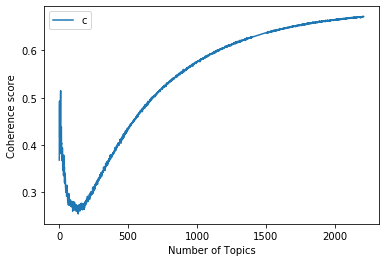

In [11]:
import matplotlib.pyplot as plt

plt.plot(topics.values[:,0], topics.values[:,1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()